In [1]:
import random
from typing import Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchio as tio
import matplotlib.pyplot as plt
from torchvision import ops

from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.python_tools import type_str
from glio.train import *
from glio.data.DS import DSToTarget
from glio.datasets import LUMIERE
from glio.python_tools import CacheRepeatIterator
from glio.jupyter_tools import clean_mem, show_slices, show_slices_arr
from glio.visualize import vis_imshow_grid, vis_imshow, Visualizer
from glio.loaders import nifti
from glio.train import *
from glio.points2 import Point, BoundingBox

## Загрузчик
Загрузчик возращает `[T1, Mask, BBox]`.

Чёрную область вокруг изображения можно удалить `[25:-25,25:-35,20:-20]`.

Получаем `132, 158, 142`

Трансформация берёт каждый 9 саггитальный срез, получаем 16 срезов из 142. Можно потом попробовать воспользоваться изменением размера.


### mean / std
- T1 image - `3567939758e+01`; `161.2564239502`
- FLAIR image - `5.9002014160e+01`; `129.0489959717`
- T1 mask - `2.4059068412e-02`; `0.2359057516`


Loading LUMIERE
['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'RANO', 'bbox', 'CT1 image', 'CT1 mask', 'CT1 necrosis bbox', 'CT1 hga-image', 'CT1 hga-mask', 'CT1 hga-non-enhancing bbox', 'CT1 hga-contrast-enhancing bbox', 'T1 hga-image', 'T1 hga-mask', 'T1 hga-non-enhancing bbox', 'T1 hga-contrast-enhancing bbox', 'T2 hga-image', 'T2 hga-mask', 'T2 hga-non-enhancing bbox', 'T2 hga-contrast-enhancing bbox', 'FLAIR hga-image', 'FLAIR hga-mask', 'FLAIR hga-non-enhancing bbox', 'FLAIR hga-contrast-enhancing bbox', 'CT1 contrast-enhancing bbox', 'CT1 edema bbox', 'T1 image', 'T1 mask', 'T1 necrosis bbox', 'T1 contrast-enhancing bbox', 'T1 edema bbox', 'T2 image', 'T2 mask', 'T2 necrosis bbox', 'T2 contrast-enhancing bbox', 'T2 edema bbox', 'FLAIR image', 'FLAIR mask', 'FLAIR necrosis bbox', 'FLAIR contrast-enhancing bbox', 'FLAIR edema bbox

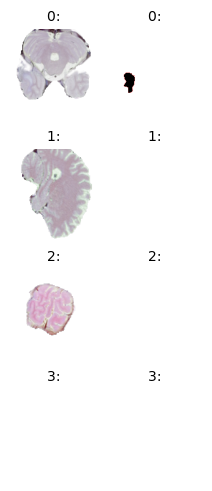

In [2]:
EVERY_SIDE, EVERY_TOP, EVERY_FRONT = 9, 9, 11
print("Loading LUMIERE")
lum = LUMIERE.LUMIERE()
print(lum.col_names())

slice_cube = (slice(15,-15),slice(33,-33),slice(15,-15))
d = lum.get_cols(["T1 image", "T2 image", "FLAIR image", "CT1 image", "T1 mask", "T1 contrast-enhancing bbox"])

def normalize(x:torch.Tensor): return (x - x.mean()) / x.std()

def one_hot_mask(mask: torch.Tensor) -> torch.Tensor:
    return F.one_hot(mask.to(torch.int64), 4).permute(2, 0, 1).to(torch.float32)

def loader(x: dict[str, torch.Tensor | list[int]]):
    images = torch.stack([nifti.read(i) for i in (x["T1 image"], x["T2 image"], x["FLAIR image"], x["CT1 image"])])[:, *slice_cube]
    mask = nifti.read(x["T1 mask"])[slice_cube]
    #images = nifti.reads([i for i in (x["T1 image"], x["T2 image"], x["FLAIR image"], x["CT1 image"])])[:, *slice_cube]
    #images = torch.stack([nifti.read(i) for i in (x["T1 image"], x["T2 image"], x["FLAIR image"], x["CT1 image"], x["T1 mask"])])[:, *slice_cube]

    # [5, 182, 218, 182] -> [5, 152, 152, 152]

    images_side = normalize(images[:,::EVERY_SIDE]) # [5, 17, 152, 152]
    mask_side = mask[::EVERY_SIDE]
    images_top = normalize(images.permute(0, 3, 2, 1)[:,::EVERY_TOP] )# [5, 17, 152, 152]
    mask_top = mask.permute(2, 1, 0)[::EVERY_TOP]
    images_front = normalize(images.permute(0, 2, 3, 1)[:,::EVERY_FRONT]) # [5, 17, 152, 152]
    mask_front = mask.permute(1, 2, 0)[::EVERY_FRONT]

    return images_side, images_top, images_front, mask_side, mask_top, mask_front# [5, 17, 152, 152], [5, 17, 152, 152], [5, 17, 152, 152]

def tfm_init(x: tuple[torch.Tensor,torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]):
    axis = random.choice([0, 1, 2])
    axis2 = axis+3
    img = x[axis]
    coord = random.randrange(0, img.shape[1])
    img = img[:, coord]
    mask = one_hot_mask(x[axis2][coord])
    return img, mask # [4, 152, 152] | (4, 152, 152 | None)

def tfm_sample(x:tuple[torch.Tensor,torch.Tensor]): return x[0]
def tfm_target(x:tuple[torch.Tensor, torch.Tensor]): return x[1]

ds = DSToTarget()
ds.add_samples(d, loader, tfm_init, tfm_sample, tfm_target)
# ds.preload(1/3)
ds_train, ds_test = ds.split(0.9, shuffle=True)
print(f'{len(ds_train) = }, {len(ds_test) = }')
ds_train.preview()

## Модель

In [3]:
class UNet_Concat_Base(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(4, 32, 4, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(32, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(48, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv6 = conv(64, 64, 4, 1, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())

        self.upconv1 = convt(64, 32, 4, 1, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.upconv2 = convt(96, 32, 2, 2, 0, 1, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.upconv3 = convt(80, 32, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.upconv4 = convt(80, 32, 2, 2, 0, 1, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.upconv5 = convt(64, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.upconv6 = convt(64, 4, 4, 2, bias=True, batch_norm=False, dropout=0.0)
    def forward(self, img:torch.Tensor):
        x2 = self.conv1(img)
        x3 = self.conv2(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
        x6 = self.conv5(x5)
        x = self.conv6(x6)

        x = self.upconv1(x)
        x = self.upconv2(torch.cat([x, x6], dim=1))
        x = self.upconv3(torch.cat([x, x5], dim=1))
        x = self.upconv4(torch.cat([x, x4], dim=1))
        x = self.upconv5(torch.cat([x, x3], dim=1))
        x = self.upconv6(torch.cat([x, x2], dim=1))
        return x
summary(UNet_Concat_Base(), (8, 4, 152, 152))

path                                         module                                       input size               output size              params    buffers   
__main__.UNet_Concat_Base/conv1/0            torch.nn.modules.conv.Conv2d                 (8, 4, 152, 152)         (8, 32, 75, 75)          2080      0         
__main__.UNet_Concat_Base/conv1/1            torch.nn.modules.activation.GELU             (8, 32, 75, 75)          (8, 32, 75, 75)          0         0         
__main__.UNet_Concat_Base/conv2/0            torch.nn.modules.conv.Conv2d                 (8, 32, 75, 75)          (8, 32, 37, 37)          9248      0         
__main__.UNet_Concat_Base/conv2/1            torch.nn.modules.activation.GELU             (8, 32, 37, 37)          (8, 32, 37, 37)          0         0         
__main__.UNet_Concat_Base/conv3/0            torch.nn.modules.conv.Conv2d                 (8, 32, 37, 37)          (8, 48, 18, 18)          6192      0         
__main__.UNet_Concat_Base/conv3/1 

Iteration 19 done.114308 loss: 0.1385505646467209465


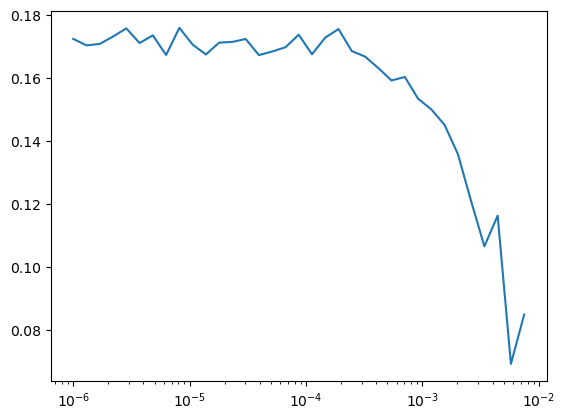

In [5]:
MODEL = UNet_Concat_Base()
BATCH_SIZE = 16
CACHE_TIMES = 256
CACHE_ELEMS = 1

LOSS_FN = nn.CrossEntropyLoss(weight = torch.tensor((0.1, 1., 1., 1.,),dtype=torch.float32,device=torch.device("cuda")))
# LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters())

dl_train = DataLoader(ds_train.cache_repeat_iterator(CACHE_TIMES, CACHE_ELEMS, True), BATCH_SIZE)
MODEL, lrs, losses = lr_finder(MODEL, OPT, LOSS_FN, dl_train, mul=1.3, end = 1, niter=20, return_best=True)

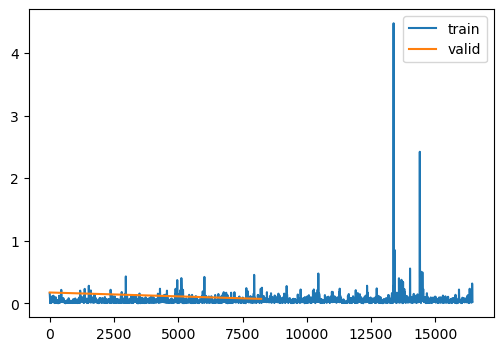

Keyboard interrupt, stopping the training...
Training took 2078.7529243000317 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.029534539207816124
 - best train MSE loss: learner.logger.min("train loss") = 0.00020449973817449063

 - last test MSE loss: learner.logger.last("test loss") = 0.0708167729658428
 - best test MSE loss: learner.logger.min("test loss") = 0.0708167729658428

 - last train L1 loss: learner.logger.last("train fn - l1_loss") = 64.94448852539062
 - best train L1 loss: learner.logger.min("train fn - l1_loss") = 0.3495273292064667

 - last test L1 loss: learner.logger.last("test fn - l1_loss") = 34.73261200148484
 - best test L1 loss: learner.logger.min("test fn - l1_loss") = 0.4249197802153127


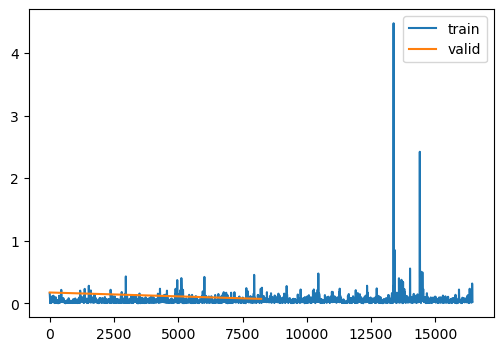

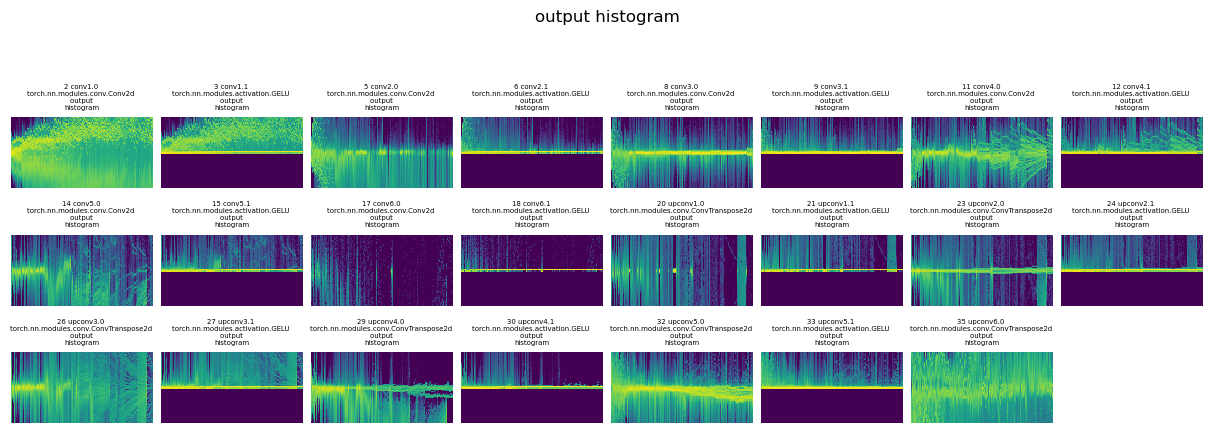

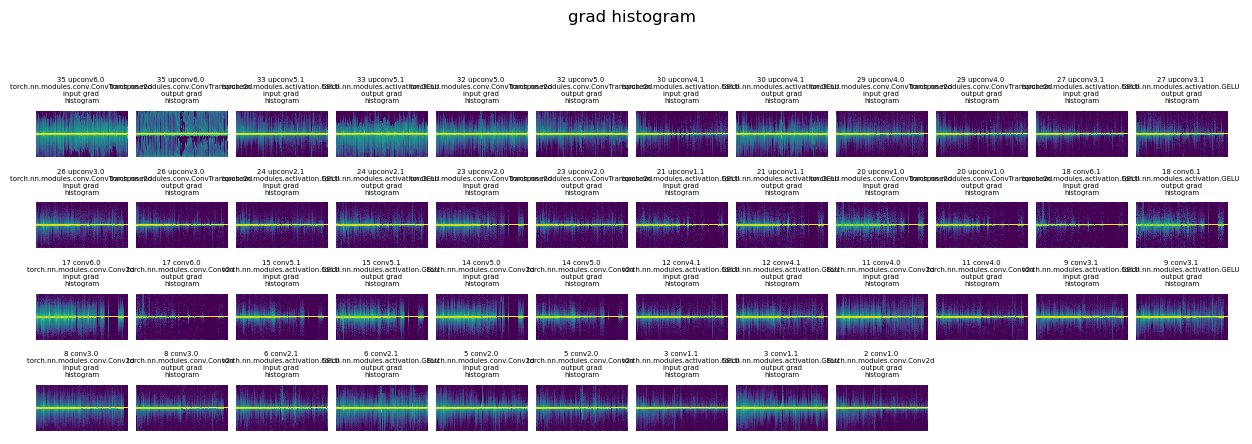

In [6]:
# MODEL = UNet_Concat_Base()
NAME = MODEL.__class__.__name__
LR = 3e-2
BATCH_SIZE = 16
CACHE_TIMES = 256
CACHE_ELEMS = 1
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_train = DataLoader(ds_train.cache_repeat_iterator(CACHE_TIMES, CACHE_ELEMS, True), BATCH_SIZE)
dl_test = DataLoader(ds_test.cache_repeat_iterator(64, CACHE_ELEMS, False), BATCH_SIZE)

LOSS_FN = nn.CrossEntropyLoss(weight = torch.tensor((0.1, 1., 1., 1.,),dtype=torch.float32,device=torch.device("cuda")))
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE segm checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} times={CACHE_TIMES} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=32), Metric_Fn(F.l1_loss), Log_GradHistorgram(32),
                         Log_SignalHistorgram(32), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - l1_loss") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - l1_loss") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - l1_loss") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - l1_loss") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

In [3]:
class UNet_Concat_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(4, 32, 4, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(32, 32, 3, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 48, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv6 = conv(64, 64, 4, 1, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())

        self.upconv1 = convt(64, 32, 4, 1, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.upconv2 = convt(96, 32, 2, 2, 0, 1, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.upconv3 = convt(80, 32, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.upconv4 = convt(80, 32, 2, 2, 0, 1, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.upconv5 = convt(64, 32, 3, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.upconv6 = convt(64, 4, 4, 2, bias=False, batch_norm=True, dropout=0.0)
    def forward(self, img:torch.Tensor):
        x2 = self.conv1(img)
        x3 = self.conv2(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
        x6 = self.conv5(x5)
        x = self.conv6(x6)

        x = self.upconv1(x)
        x = self.upconv2(torch.cat([x, x6], dim=1))
        x = self.upconv3(torch.cat([x, x5], dim=1))
        x = self.upconv4(torch.cat([x, x4], dim=1))
        x = self.upconv5(torch.cat([x, x3], dim=1))
        x = self.upconv6(torch.cat([x, x2], dim=1))
        return x
summary(UNet_Concat_BatchNorm(), (8, 4, 152, 152))

path                                         module                                       input size               output size              params    buffers   
__main__.UNet_Concat_BatchNorm/conv1/0       torch.nn.modules.conv.Conv2d                 (8, 4, 152, 152)         (8, 32, 75, 75)          2048      0         
__main__.UNet_Concat_BatchNorm/conv1/1       torch.nn.modules.activation.GELU             (8, 32, 75, 75)          (8, 32, 75, 75)          0         0         
__main__.UNet_Concat_BatchNorm/conv1/2       torch.nn.modules.batchnorm.BatchNorm2d       (8, 32, 75, 75)          (8, 32, 75, 75)          64        65        
__main__.UNet_Concat_BatchNorm/conv2/0       torch.nn.modules.conv.Conv2d                 (8, 32, 75, 75)          (8, 32, 37, 37)          9216      0         
__main__.UNet_Concat_BatchNorm/conv2/1       torch.nn.modules.activation.GELU             (8, 32, 37, 37)          (8, 32, 37, 37)          0         0         
__main__.UNet_Concat_BatchNorm/con

lr: 0.012646218552730359 loss: 0.1489023417234420857


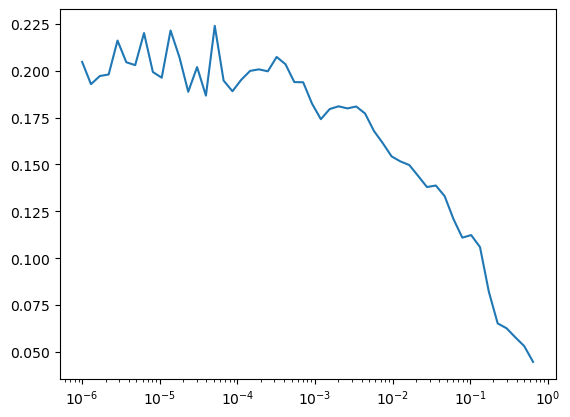

In [5]:
MODEL = UNet_Concat_BatchNorm()
BATCH_SIZE = 16
CACHE_TIMES = 16
CACHE_ELEMS = 1

LOSS_FN = nn.CrossEntropyLoss(weight = torch.tensor((0.1, 1., 1., 1.,),dtype=torch.float32,device=torch.device("cuda")))
# LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters())

dl_train = DataLoader(ds_train.cache_repeat_iterator(CACHE_TIMES, CACHE_ELEMS, True), BATCH_SIZE)
MODEL, lrs, losses = lr_finder(MODEL, OPT, LOSS_FN, dl_train, mul=1.3, end = 1, niter=20, return_best=True) # type:ignore

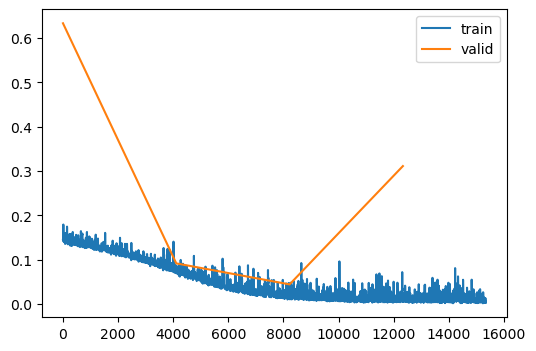

In [6]:
# MODEL = UNet_Concat_BatchNorm()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_TIMES = 128
CACHE_ELEMS = 1
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_train = DataLoader(ds_train.cache_repeat_iterator(CACHE_TIMES, CACHE_ELEMS, True), BATCH_SIZE)
dl_test = DataLoader(ds_test.cache_repeat_iterator(64, CACHE_ELEMS, False), BATCH_SIZE)

LOSS_FN = nn.CrossEntropyLoss(weight = torch.tensor((0.1, 1., 1., 1.,),dtype=torch.float32,device=torch.device("cuda")))
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE segm checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} times={CACHE_TIMES} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME, # type:ignore
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=32), Metric_Fn(F.l1_loss), Log_GradHistorgram(32),
                         Log_SignalHistorgram(32), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - l1_loss") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - l1_loss") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - l1_loss") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - l1_loss") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")